In [1]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise
from scipy.ndimage import zoom

# 10. Selection of preferred energy compaction options

The remainder of this project will concentrate on developing the rest of
an image compression system, based on a few of the filtering /
transformation schemes studied so far.

Since the subsequent processes are non-linear, we cannot expect to be able to
choose precisely the right front-end at this stage, so we adopt the pragmatic
approach of picking about three good candidates and trust that one of these
will lead to a near-optimum solution in the end. Remember that up to this point we have only been using entropy to give us an _estimate_ of the number of bits required, the accuracy of which is affected by subsequent stages.

At this stage it is worth trying your schemes with all three
test images, (`Lighthouse`, `Bridge`, and `Flamingo`). You will find `Bridge` more difficult to compress than the other two. You may also want to introduce other images of your own.

In [2]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

In [11]:
# import scipy.io
# import numpy as np
# from PIL import Image

# # List of TIFF image paths
# tif_image_paths = ['comp']
# mat_file_paths = ['lake.mat', 'boats.mat', 'baboon.mat', 'couple.mat', 'plane.mat']

# # Process each image
# for tif_path, mat_path in zip(tif_image_paths, mat_file_paths):
#     # Load the TIFF image
#     img = Image.open(tif_path).convert("L")  # Convert to grayscale if necessary
    
#     # Convert the image to a NumPy array
#     img_array = np.array(img)
    
#     # Save the image array to a MAT file
#     scipy.io.savemat(mat_path, {'image': img_array})
#     print(f'{tif_path} has been converted to {mat_path}')

# # List the created files
# mat_file_paths

In [3]:
lena, _ = load_mat_img(img='lena.mat', img_info='image')
peppers, _ = load_mat_img(img='peppers.mat', img_info='image')
columbia, _ = load_mat_img(img='columbia.mat', img_info='image')
camera, _ = load_mat_img(img='camera.mat', img_info='image')

print(columbia.shape)

(480, 480)


In [4]:
peppers = zoom(peppers, 256/512)
columbia = zoom(columbia, 256/480)
lena = zoom(lena, 256/512)

print(peppers.shape, columbia.shape, lena.shape)

(256, 256) (256, 256) (256, 256)


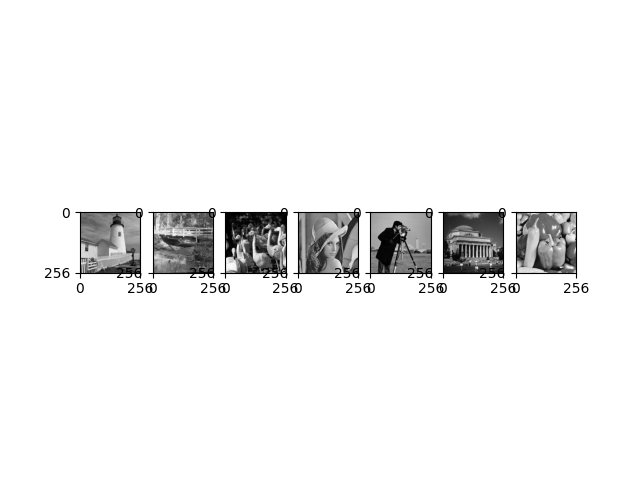

In [5]:
fig, axs = plt.subplots(1, 7)
plot_image(lighthouse, ax=axs[0])
plot_image(bridge, ax=axs[1])
plot_image(flamingo, ax=axs[2])
plot_image(lena, ax=axs[3])
plot_image(camera, ax=axs[4])
plot_image(columbia, ax=axs[5])
plot_image(peppers, ax=axs[6])

Write `.py` files to implement each of your
chosen schemes, so that you do not have to remember long sequences
of commands each time you run them. You can easily edit the M-files to introduce different options
later.  Using plenty of comments in these files will help when you want to change them.

# 11. Centre-clipped linear quantisers

The quantisers that you have used so far have all been uniform quantisers
(i.e.  all steps have been the same size).  However the probability
distributions of the intensities of the bandpass sub-images from the energy
compaction front-ends are usually highly peaked at zero.  The amount of data
compression depends heavily on the proportion of data samples which are
quantised to zero; if this approaches unity then high compression is
achieved.

Hence it is often found desirable to make the quantiser non-linear
so that more samples tend to be quantised to zero.  A simple way
to achieve this is to widen the step-size of the "zero" step.  In
a uniform quantiser, the "zero" step is normally centred on zero,
with rises to the next level at $\pm$ half of the step-size on
each side of zero. `quantise` allows a third argument `rise1` to be specified, which is
the point at which the first rise occurs on each side of the zero step.  A
value of `rise1` = `step/2` is the default, but `rise1` = $\left\{0.5, 1, 1.5\right\}\times$ `step` are worth investigating. To show what effect these have, try:

```python
x = np.arange(-100, 100+1)
y = quantise(x, 20, rise1)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
```

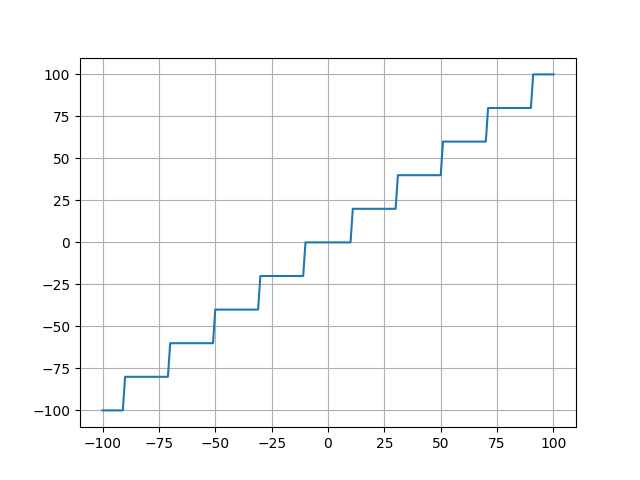

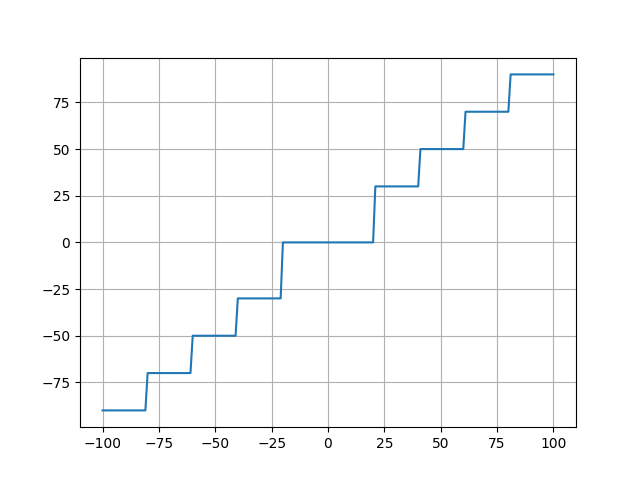

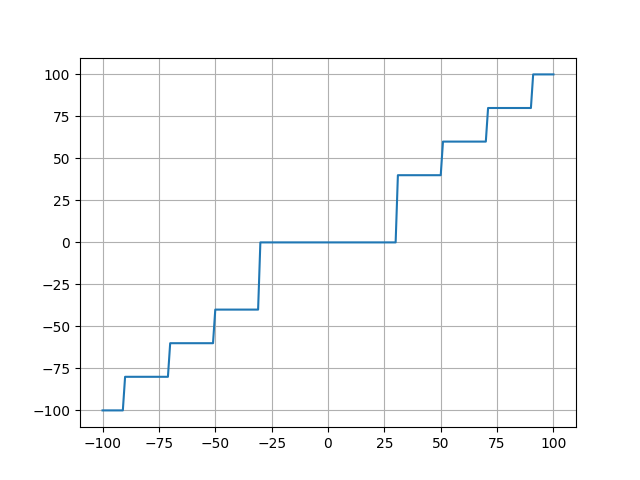

In [6]:
# your code here
for rise1 in [0.5, 1, 1.5]:
    step = 20
    rise1 = step*rise1
    x = np.arange(-100, 100+1)
    y = quantise(x, step, rise1)
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.grid()

A wider zero step means that more samples will be coded as zero and so the
entropy of the data will be reduced.  The use of a wide zero step is
beneficial if it results in a better entropy vs. error tradeoff than a uniform
quantiser.

<div class="alert alert-block alert-danger">

For each of your preferred front-end
schemes, investigate the effects of varying the first rise of the
quantiser.  To do this, you could plot how the quantising error
varies as a function of the number of bits for a few different ratios of
`rise1` to step-size, and hence find the ratio which gives the
best compression for a given rms error. </div>

In [7]:
lighthouse = lighthouse - 128.0
bridge = bridge - 128.0
camera = camera - 128.0
flamingo = flamingo - 128.0
columbia = columbia - 128.0
lena = lena - 128.0
peppers = peppers - 128.0

In [17]:
# You may wish to work in standalone python files (instead of notebooks) at this point!
from chosen_schemes.dct import reconstruct_dct, find_step_size_for_compression_bits_dct
from chosen_schemes.lbt import reconstruct_lbt, find_step_size_for_compression_bits_lbt
from chosen_schemes.dwt import reconstruct_dwt, find_step_size_for_compression_bits_dwt, compute_ss_ratios

rise_ratios = [0.5, 0.75, 1, 1.25, 1.5]
target_bits_range = np.linspace(10000, 300000, 100)
results_dct = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}
results_lbt = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}
results_dwt = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}

image = lighthouse

9976.96097682506 17.772022423980513 188.0111880570684
12926.374823932028 15.857821877977642 151.7978242497038
15856.739083466216 14.295673385378025 124.85094426540967
18494.67849017864 13.355117044169937 109.33535706987072
20510.01398784798 12.663250614439374 99.8117705610138
24648.54447163132 11.49632083456248 84.60304819880946
27584.281452916504 10.755910308767227 75.54003454097179
30505.22061056211 10.130705637470502 68.55281253847518
33434.19153098234 9.576683713300136 62.57848554129625
36360.730260741984 9.059309896339837 57.321741597102616
39293.45945795264 8.623043734448375 53.016539235274294
42222.435213986646 8.173669364297647 49.09524968690547
45145.75663536878 7.791451463518976 45.57587299542877
48083.181262766186 7.4190046645411964 42.415450915705044
51011.71171110104 7.10360250265379 39.725964255317976
53937.13896757756 6.8005583596845485 37.322214907305344
56856.71328764352 6.51887063829968 35.12387609837502
59797.43176063665 6.250522438567775 33.12324600940915
62725.4315

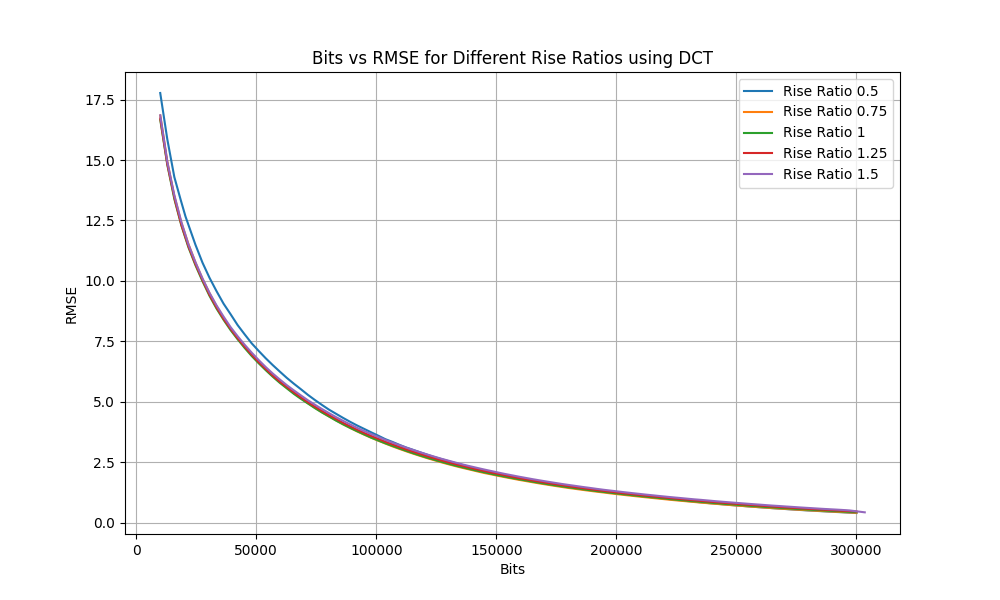

In [18]:
for rise in rise_ratios:
    for target_bits in target_bits_range:
        step_size = find_step_size_for_compression_bits_dct(image, 8, target_bits, rise, min_step_size=0.01, max_step_size=200, tolerance=1e-5)
        bits_dct, rmse_dct, Z_dct = reconstruct_dct(image, step_size, 8, rise)
        print(bits_dct, rmse_dct, step_size)
        results_dct[rise]['bits'].append(bits_dct)
        results_dct[rise]['rmse'].append(rmse_dct)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_dct[rise]['bits'], results_dct[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)
plt.show()


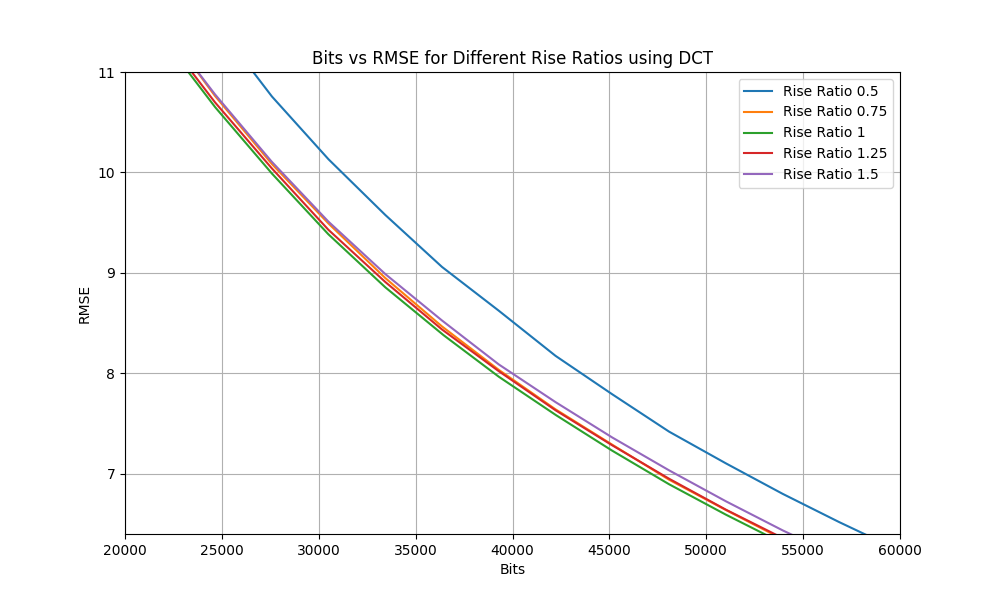

In [28]:
plt.figure(figsize=(10, 6))

# Plotting the main graph
for rise in rise_ratios:
    plt.plot(results_dct[rise]['bits'], results_dct[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)

# Setting the x and y axis limits for the constrained portion
plt.xlim(20000, 60000)
plt.ylim(6.4,11)

plt.show()

10255.807409606525 19.295229431558766 199.8199779923235
12929.55415698153 15.824828003339295 157.51733254758162
15893.604668712018 13.967288319591097 131.63571041167785
18780.673712006846 12.559214836318318 111.33097151156987
21718.818231995712 11.42999533392244 96.81484971470263
24644.382021101188 10.654394247812224 85.8299512198179
27573.610956106073 9.790793559105085 76.44864199628717
30501.75858319621 9.115064039187867 68.81927576060698
33434.71060978425 8.49679534557159 61.92531772219206
36366.8196343939 7.9760367245010695 56.46265774752052
39290.05485967604 7.517223810548707 51.64551316176422
42218.04041293034 7.070450216456338 47.493081022755824
45152.4120084454 6.71878511782428 44.03199973613479
48018.72186643353 6.360157820322792 40.88093139366125
51011.65372307652 6.042853976687081 37.93121404910329
53942.22737904792 5.750195557639886 35.32929943294848
56749.36296999005 5.468187529753524 33.00531526842927
59674.85952479779 5.20825018218431 30.861812192589717
62729.32337785688

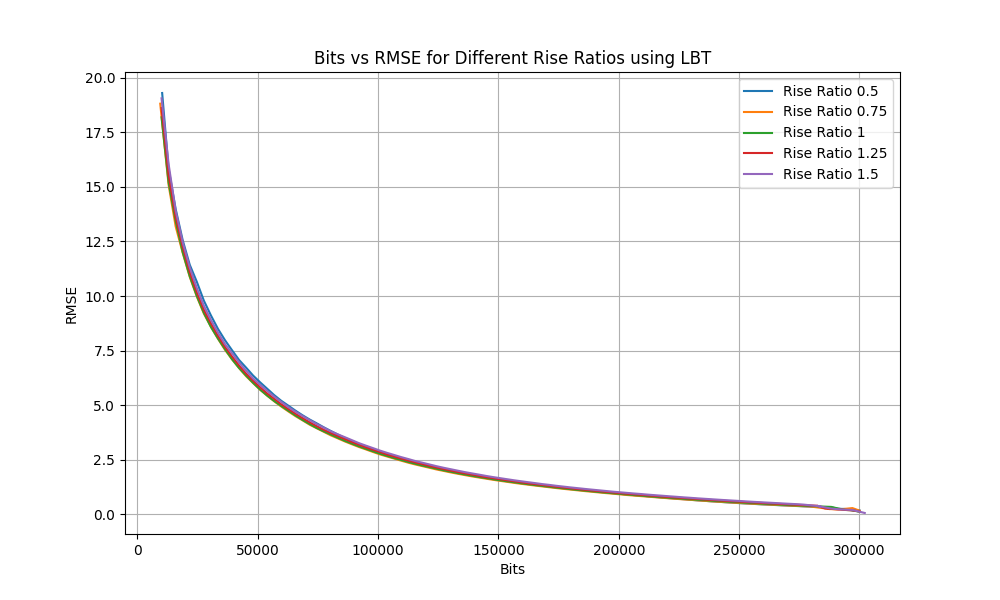

In [20]:
for rise in rise_ratios:
    for target_bits in target_bits_range:
        step_size = find_step_size_for_compression_bits_lbt(image, 4, target_bits, rise, min_step_size=0.01, max_step_size=200, tolerance=1e-5)
        bits_dct, rmse_dct, Z_dct = reconstruct_lbt(image, step_size, rise, N=4, s=1.32)
        print(bits_dct, rmse_dct, step_size)
        results_lbt[rise]['bits'].append(bits_dct)
        results_lbt[rise]['rmse'].append(rmse_dct)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_lbt[rise]['bits'], results_lbt[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using LBT')
plt.legend()
plt.grid(True)
plt.show()

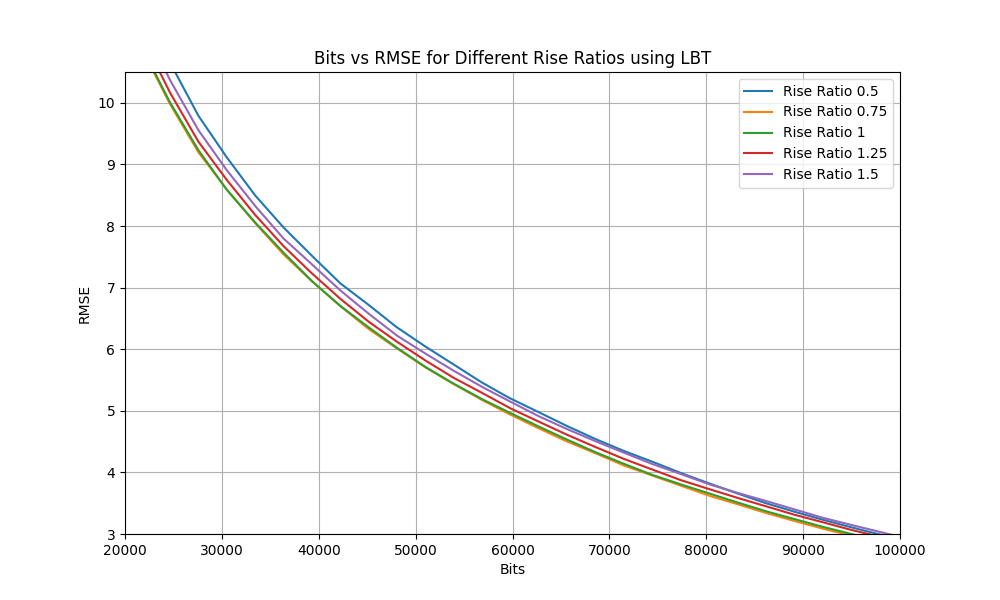

In [21]:
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_lbt[rise]['bits'], results_lbt[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using LBT')
plt.legend()
plt.grid(True)

# Setting the x and y axis limits for the constrained portion
plt.xlim(20000, 100000)
plt.ylim(3, 10.5)

plt.show()

9992.584132023192 18.226588000509256 7.841088441111176
12930.571750224171 16.896145675792233 6.817163244678451
15871.504225903287 15.40837330516492 5.931028055811403
18786.615363846868 14.069672904301038 5.189004757849106
21720.12209844075 12.927896065729575 4.617366695459056
24639.967661069844 12.088422690414315 4.1436991375134555
27581.041986616332 11.270578004008497 3.761342076522319
30525.203277128036 10.464110869733425 3.4051864995638197
33436.11271717172 9.75962435505596 3.090936289684613
36344.41018284469 9.159806829978265 2.821979601821789
39295.3771615605 8.73242590228369 2.601066980843898
42236.2931345004 8.232542782805256 2.395234920968999
45251.13985191076 7.780573133524241 2.2125977387170574
48104.99628371687 7.325802464110602 2.0608875116988687
51009.757157666565 6.962960684925611 1.920533693357276
53910.8043210558 6.621535690126617 1.7848645198746136
56884.88752988993 6.314454550160127 1.6667862868311931
59835.26391808386 6.030159247955973 1.565805811776325
62723.1324927

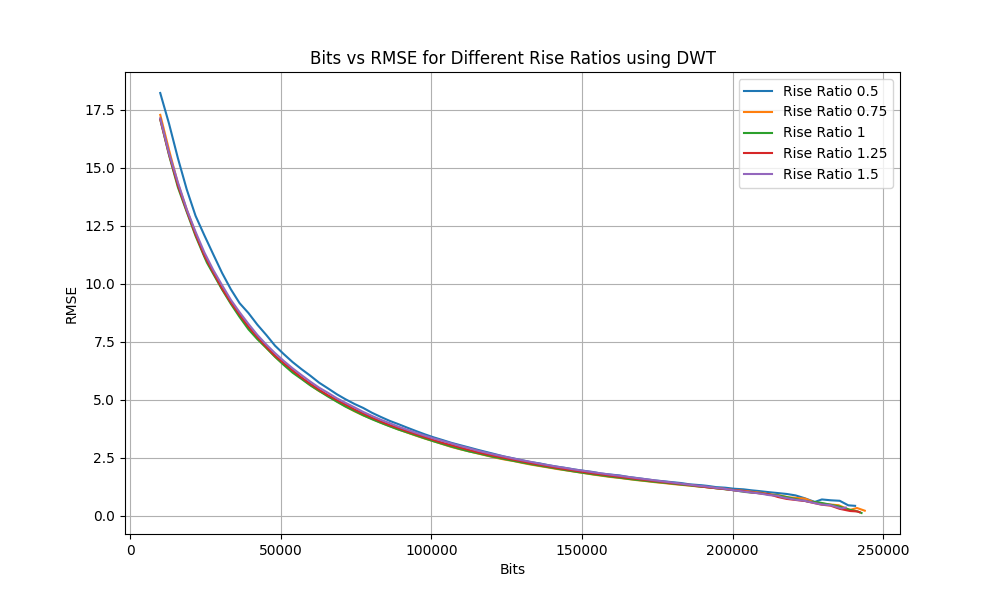

In [22]:
for rise in rise_ratios:
    for target_bits in target_bits_range:
        ssrs = compute_ss_ratios(5)
        overall_mult = find_step_size_for_compression_bits_dwt(ssrs, image, 5, target_bits, rise, min_om=0.01, max_om=50, tolerance=1e-5)
        bits_dwt, rmse_dwt, Z_dwt = reconstruct_dwt(image, ssrs, overall_mult, 5, rise)
        print(bits_dwt, rmse_dwt, overall_mult)
        results_dwt[rise]['bits'].append(bits_dwt)
        results_dwt[rise]['rmse'].append(rmse_dwt)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_dwt[rise]['bits'], results_dwt[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DWT')
plt.legend()
plt.grid(True)
plt.show()

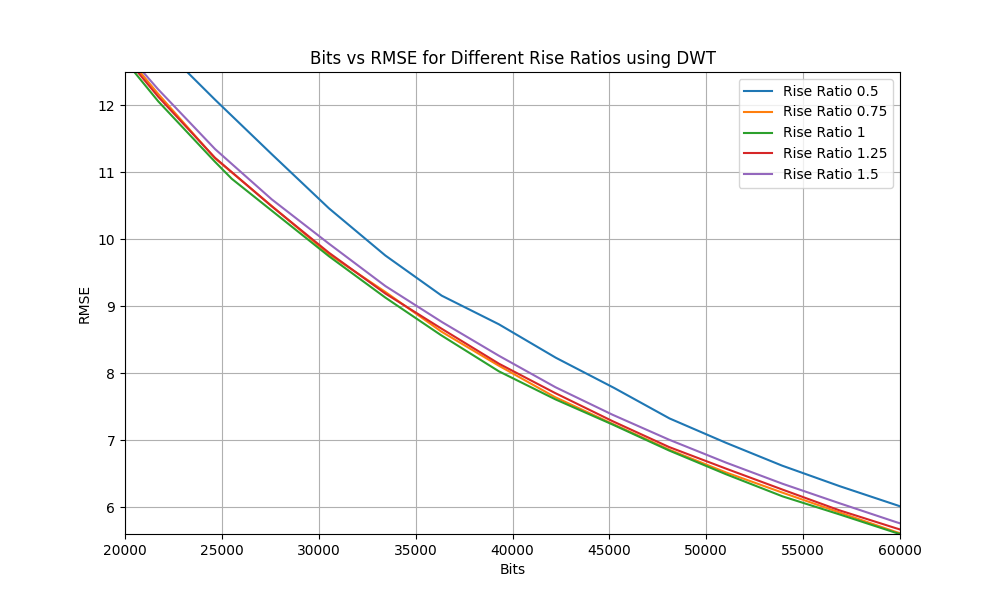

In [29]:
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_dwt[rise]['bits'], results_dwt[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DWT')
plt.legend()
plt.grid(True)

# Setting the x and y axis limits for the constrained portion
plt.xlim(20000, 60000)
plt.ylim(5.6, 12.5)

plt.show()

Most current image compression standards use quantisers with a
double-width centre step (`rise1 = step`). Do not spend too much time
on this as the compression gains are likely to be quite small.

<div class="alert alert-block alert-danger">


Discuss whether your results indicate that `rise1 = step`
is a reasonable compromise if all quantisers are to be similar.
</div>

A final strategy which you can consider is to completely suppress some
sub-images or DCT coefficients.  This is equivalent to increasing `rise1`
to a very large value for these components.  In the sub-images / coefficients
which represent only the highest horizontal and vertical frequency components
combined, the effects of suppression can be almost unnoticable and yet
a useful saving in number of bits can be achieved.

<div class="alert alert-block alert-danger">

Investigate any additional gains which can be achieved with suppression
of some sub-images / coefficients.
</div>

222.8313222786069 49.771762969120445 188.0111880570684
249.25439558018624 49.748873716930376 151.7978242497038
267.98365704577435 49.75430007738679 124.85094426540967
281.26239631165794 49.75196138029289 109.33535706987072
303.7795492662 49.74463147633689 99.8117705610138
333.1788459405175 49.747483073943776 84.60304819880946
340.27814038231804 49.74717266678471 75.54003454097179
359.4430881299416 49.74614282790857 68.55281253847518
397.43137181695414 49.743140736095896 62.57848554129625
417.19052929205935 49.74498450610628 57.321741597102616
430.17479921962826 49.74365876464335 53.016539235274294
457.8622032205665 49.74233655312131 49.09524968690547
500.35813408798776 49.74158665103936 45.57587299542877
533.4336034998 49.743271754160716 42.415450915705044
565.180839603909 49.74340865539356 39.725964255317976
583.608095106475 49.594341176767344 37.322214907305344
614.4366961941281 49.46143249728859 35.12387609837502
646.7057137206866 49.3425713861961 33.12324600940915
710.4470361533118

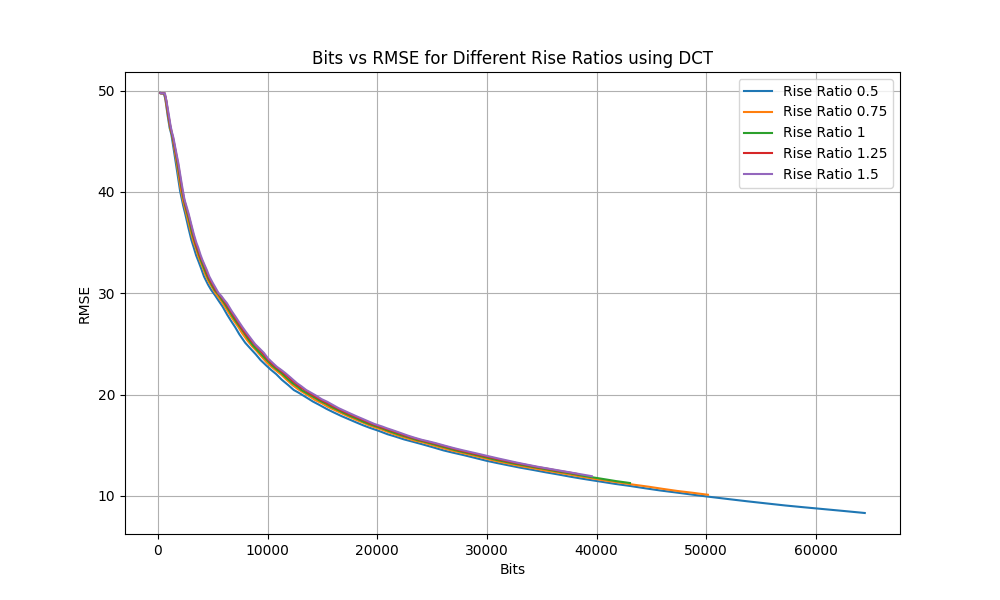

In [24]:
from chosen_schemes.dct import reconstruct_dct_suppressed_hf

image = lighthouse
results_dct_supp = {0.5: {'bits': [], 'rmse': []}, 0.75: {'bits': [], 'rmse': []}, 1: {'bits': [], 'rmse': []}, 1.25: {'bits': [], 'rmse': []}, 1.5: {'bits': [], 'rmse': []}}

for rise in rise_ratios:
    for target_bits in target_bits_range:
        step_size = find_step_size_for_compression_bits_dct(image, 8, target_bits, rise, min_step_size=0.01, max_step_size=200, tolerance=1e-5)
        bits_dct, rmse_dct, Z_dct = reconstruct_dct_suppressed_hf(image, step_size, 8, rise)
        print(bits_dct, rmse_dct, step_size)
        results_dct_supp[rise]['bits'].append(bits_dct)
        results_dct_supp[rise]['rmse'].append(rmse_dct)

# Plot the results
plt.figure(figsize=(10, 6))

for rise in rise_ratios:
    plt.plot(results_dct_supp[rise]['bits'], results_dct_supp[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)
plt.show()






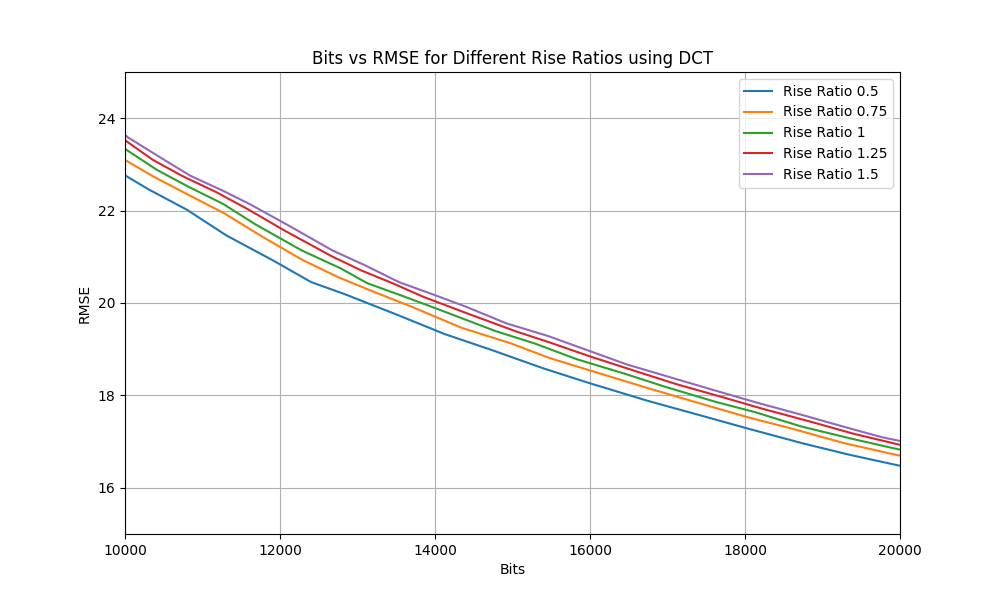

In [25]:
plt.figure(figsize=(10, 6))

# Plotting the main graph
for rise in rise_ratios:
    plt.plot(results_dct_supp[rise]['bits'], results_dct_supp[rise]['rmse'], label=f'Rise Ratio {rise}')

plt.xlabel('Bits')
plt.ylabel('RMSE')
plt.title('Bits vs RMSE for Different Rise Ratios using DCT')
plt.legend()
plt.grid(True)

# Setting the x and y axis limits for the constrained portion
plt.xlim(10000, 20000)
plt.ylim(15, 25)

plt.show()